## 객실 사용 여부 관련 데이터
1. 데이터를 탐색하고 시각화(EDA)
2. 결측치를 탐색하고 대체
3. 데이터의 불균형이 존재하는가, 존재한다면서 시각화를 통해서 표시
4. 데이터 오버샘플링
    - 원데이터, 랜덤오버샘플링, SMOTE 3개의 데이터 셋 구성
5. 랜덤포레스트 분류 분석으로 3개의 데이터셋의 정확도와 속도 측면으로 어떠한가 확인

In [47]:
import pandas as pd
import numpy as np

In [48]:
hotel = pd.read_csv("./data/hotel_bookings.csv")
hotel.head()

,is_canceled,deposit_type,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr
0,0,No Deposit,105.0,2,5,NaN,0,0,1,0,131.50
1,0,No Deposit,303.0,2,2,NaN,0,0,0,0,73.95
2,0,No Deposit,33.0,2,3,0.0,0,0,0,0,NaN
3,0,No Deposit,48.0,0,1,0.0,0,0,1,0,80.30
4,0,No Deposit,216.0,4,7,0.0,0,0,2,0,60.90


In [49]:
## 결측치 확인 
hotel.isna().sum()

is_canceled                          0
deposit_type                         0
lead_time                            5
stays_in_weekend_nights              0
stays_in_week_nights                 0
is_repeated_guest                  358
previous_cancellations               0
previous_bookings_not_canceled       0
booking_changes                      0
days_in_waiting_list                 0
adr                               1063
dtype: int64

is_canceled 예약 취소 여부 (0=취소 안 됨, 1=취소됨)

deposit_type 보증금 유형 (No Deposit, Non Refund, Refundable)

lead_time 예약일과 실제 도착일 사이의 일수

stays_in_weekend_nights 주말(토·일) 숙박 일수

stays_in_week_nights 주중(월~금) 숙박 일수

is_repeated_guest 재방문 고객 여부 (0=신규, 1=재방문)

previous_cancellations 과거 예약 취소 횟수

previous_bookings_not_canceled 과거 예약 중 취소되지 않은 건수

booking_changes 예약 후 변경 횟수

days_in_waiting_list 대기자 명단에 있었던 일수

adr 평균 일일 객실 요금 (Average Daily Rate)

In [50]:
## 데이터 타입 
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     20000 non-null  int64  
 1   deposit_type                    20000 non-null  object 
 2   lead_time                       19995 non-null  float64
 3   stays_in_weekend_nights         20000 non-null  int64  
 4   stays_in_week_nights            20000 non-null  int64  
 5   is_repeated_guest               19642 non-null  float64
 6   previous_cancellations          20000 non-null  int64  
 7   previous_bookings_not_canceled  20000 non-null  int64  
 8   booking_changes                 20000 non-null  int64  
 9   days_in_waiting_list            20000 non-null  int64  
 10  adr                             18937 non-null  float64
dtypes: float64(3), int64(7), object(1)
memory usage: 1.7+ MB


In [51]:
## 종속 변수 특징 파악 
hotel.deposit_type.describe()

count          20000
unique             3
top       No Deposit
freq           19138
Name: deposit_type, dtype: object

In [52]:
hotel.groupby(hotel['deposit_type']).mean()['adr']

deposit_type
No Deposit    101.965190
Non Refund     89.689476
Refundable     67.456154
Name: adr, dtype: float64

- 결측치의 존재 여부
    - 결측치가 존재하는 변수는 3개
    - 결측치의 총 개수는 1426개
    - 결측치가 존재하는 변수들은 비율과 분포에 따라 각각 다른 결측치 대체 방식 사용
- 데이터 타입
    - 종속 변수 int
    - 독립 변수 object, int, float
    - object 타입은 인코딩을 통하여 변환
- 종속 변수 특징
    - object형
    - 변수는 20000개 중에 19138개의 관측치가 No Deposit

In [53]:
## 결측치의 비율 확인 
print('lead time 결측치 비율 : ', round(5 / len(hotel)*100, 2))
print('is repeated guest 결측치 비율 :', round(358 / len(hotel) * 100 , 2))
print('adr 결측치 비율 :', round(1063 / len(hotel) * 100, 2))

lead time 결측치 비율 :  0.03
is repeated guest 결측치 비율 : 1.79
adr 결측치 비율 : 5.32


- lead_time 변수는 결측치가 1% 미만이므로 결측치가 있는 행을 삭제
- is_repreated_guest 변수의 결측치는 최빈값으로 대체
- adr 변수의 결측치는 deposit_type별 평균으로 adr을 대체

In [54]:
## is_repreated_guest 컬럼의 최빈값
hotel['is_repeated_guest'].value_counts()

is_repeated_guest
0.0    18893
1.0      749
Name: count, dtype: int64

In [55]:
hotel_nonull = hotel

## lead_time컬럼의 결측치 제거
hotel_nonull.dropna(subset=['lead_time'], axis=0, inplace=True)

## is_repeated_guest 컬럼은 최빈값(0) 대체
hotel_nonull['is_repeated_guest'].fillna(0)

## adr 변수는 연속형 변수이기 때문에 평균대치법 사용
## 보증금 유형에 따라 adr이 다르기 때문에 그룹별 평균의 값을 대체
fill_mean_func = lambda g : g.fillna(g.mean())
hotel_nonull = hotel_nonull.groupby('deposit_type').apply(fill_mean_func)

hotel_nonull.isna().sum()

is_canceled                       0
lead_time                         0
stays_in_weekend_nights           0
stays_in_week_nights              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
dtype: int64

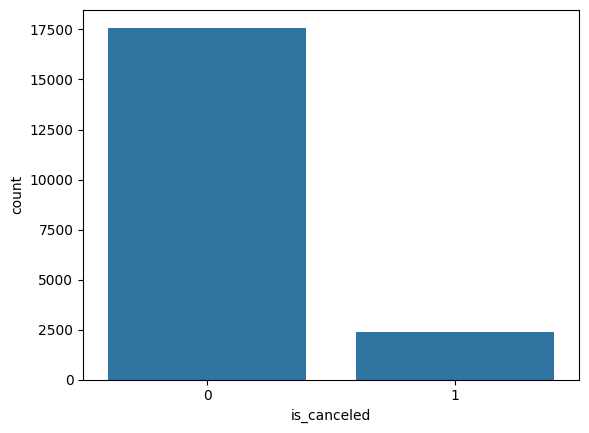

0의 비율 : 88.0
1의 비율 : 12.0


In [56]:
## 데이터 불균형 시각화 
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = 'is_canceled', data = hotel_nonull)
plt.show()

ratio0 = round(len(hotel_nonull[hotel_nonull['is_canceled'] == 0]) / len(hotel_nonull) * 100 , 2)
ratio1 = round(len(hotel_nonull[hotel_nonull['is_canceled'] == 1]) / len(hotel_nonull) * 100 , 2)

print("0의 비율 :", ratio0)
print("1의 비율 :", ratio1)

In [57]:
hotel_nonull.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 19995 entries, ('No Deposit', np.int64(0)) to ('Refundable', np.int64(16851))
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     19995 non-null  int64  
 1   lead_time                       19995 non-null  float64
 2   stays_in_weekend_nights         19995 non-null  int64  
 3   stays_in_week_nights            19995 non-null  int64  
 4   is_repeated_guest               19995 non-null  float64
 5   previous_cancellations          19995 non-null  int64  
 6   previous_bookings_not_canceled  19995 non-null  int64  
 7   booking_changes                 19995 non-null  int64  
 8   days_in_waiting_list            19995 non-null  int64  
 9   adr                             19995 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 2.2+ MB


In [58]:
## 랜덤오버 샘플링, SMOTE 
from imblearn.over_sampling import RandomOverSampler, SMOTE
import time

In [59]:
##원본 데이터 
x = hotel_nonull[hotel_nonull.columns.difference(['is_canceled'])]
y = hotel_nonull['is_canceled']

In [60]:
## 랜덤오버샘플링
start = time.time()
ros = RandomOverSampler(random_state=42)
x_ro, y_ro = ros.fit_resample(x, y)
end = time.time()
print(f"{end - start}")

0.00531315803527832


In [61]:
## SMOTE
start = time.time()
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x, y)
end = time.time()
print(f"{end - start}")

0.011993646621704102


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [63]:
## 원데이터를 이용한 랜덤포레스트
start = time.time()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state=100)
clf = RandomForestClassifier(n_estimators=100, min_samples_split=10)
clf.fit(x_train, y_train)
print("train 정확도 :", clf.score(x_train, y_train), '\n')
pred = clf.predict(x_test)
end = time.time()
print(classification_report(y_test, pred))
print(f"{end - start}")

train 정확도 : 0.930545136284071 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3519
           1       0.91      0.32      0.47       480

    accuracy                           0.91      3999
   macro avg       0.91      0.66      0.71      3999
weighted avg       0.91      0.91      0.90      3999

0.8624727725982666


In [64]:
## 랜덤오버샘플링
start = time.time()
x_ro_train, x_ro_test, y_ro_train, y_ro_test = train_test_split(x_ro, y_ro, test_size = 0.2, stratify = y_ro, random_state=100)
clf_ro = RandomForestClassifier(n_estimators=100, min_samples_split=10)
clf_ro.fit(x_ro_train, y_ro_train)
print("train 정확도 :", clf_ro.score(x_ro_train, y_ro_train), '\n')
pred_ro = clf_ro.predict(x_ro_test)
end = time.time()
print(classification_report(y_ro_test, pred_ro))
print(f"{end - start}")

train 정확도 : 0.9842639954532537 

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      3519
           1       0.92      0.97      0.95      3519

    accuracy                           0.95      7038
   macro avg       0.95      0.95      0.95      7038
weighted avg       0.95      0.95      0.95      7038

1.4123365879058838


In [65]:
## SMOTE 
start = time.time()
x_sm_train, x_sm_test, y_sm_train, y_sm_test = train_test_split(x_sm, y_sm, test_size = 0.2, stratify=y_sm, random_state=100)
clf_sm = RandomForestClassifier(n_estimators=100, min_samples_split=10)
clf_sm.fit(x_sm_train, y_sm_train)
print("train 정확도 :", clf_sm.score(x_sm_train, y_sm_train))
pred_sm = clf_sm.predict(x_sm_test)
end = time.time()
print(classification_report(y_sm_test, pred_sm))
print(f"{end - start}")

train 정확도 : 0.9616013071895425
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3519
           1       0.87      0.87      0.87      3519

    accuracy                           0.87      7038
   macro avg       0.87      0.87      0.87      7038
weighted avg       0.87      0.87      0.87      7038

1.8835487365722656


In [66]:
raw = 1.7895405292510986
ro = 0.018232345581054688 + 2.815408945083618
sm = 0.03938770294189453 + 3.539316177368164
print("원본 데이터셋의 모델링 수행 속도 :", raw)
print("RO 데이터셋의 모델링 수행 속도 :", ro)
print("SMOTE 데이터셋의 모델링 수행 속도 :", sm)

원본 데이터셋의 모델링 수행 속도 : 1.7895405292510986
RO 데이터셋의 모델링 수행 속도 : 2.833641290664673
SMOTE 데이터셋의 모델링 수행 속도 : 3.5787038803100586


- 이번 모델링에서는 RO이 속도면에서나 정확도 면에서 모두 가장 우수하게 나왔다